In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

In [3]:

eng18 = pd.read_excel('Engsoccer2017-18.xlsx')
print(eng18.columns.tolist())

['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']


In [4]:
eng18.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H


In [24]:
eng18["hwin"] = np.where(eng18["FTR"]=="H", 1, np.where(eng18["FTR"]=="D", 0.5, 0))
eng18["awin"] = np.where(eng18["FTR"]=="A", 1, np.where(eng18["FTR"]=="D", 0.5, 0))
eng18["counter"] = 1
assert len(eng18[(eng18["hwin"] == 1) & (eng18["awin"] == 1)]) == 0
eng18.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,hwin,awin,counter
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H,1.0,0.0,1
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A,0.0,1.0,1
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A,0.0,1.0,1
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A,0.0,1.0,1
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H,1.0,0.0,1


In [50]:
home_df = eng18.groupby(["HomeTeam", "Div"])["FTHG", "FTAG", "hwin", "counter"].sum().reset_index()
home_df.rename(columns=dict(HomeTeam="team", FTHG="scoredH", FTAG="concededH", counter="HG"), inplace=True)
home_df

/tmp/ipykernel_569503/803319522.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  home_df = eng18.groupby(["HomeTeam", "Div"])["FTHG", "FTAG", "hwin", "counter"].sum().reset_index()


,team,Div,scoredH,concededH,hwin,HG
0,AFC Wimbledon,FL1,25,30,11.0,23
1,Accrington,FL2,42,19,18.5,23
2,Arsenal,EPL,54,20,16.0,19
3,Aston Villa,FLCH,42,19,17.5,23
4,Barnet,FL2,24,25,11.0,23
...,...,...,...,...,...,...
87,West Ham,EPL,24,26,10.0,19
88,Wigan,FL1,37,11,17.0,23
89,Wolves,FLCH,47,18,18.5,23
90,Wycombe,FL2,43,35,14.5,23


In [57]:
away_df = eng18.groupby("AwayTeam")["FTHG", "FTAG", "awin", "counter"].sum().reset_index()
away_df.rename(columns=dict(AwayTeam="team", FTHG="concededA", FTAG="scoredA", counter="AG"), inplace=True)
away_df

/tmp/ipykernel_569503/2798072298.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  away_df = eng18.groupby("AwayTeam")["FTHG", "FTAG", "awin", "counter"].sum().reset_index()


,team,concededA,scoredA,awin,AG
0,AFC Wimbledon,28,22,9.0,23
1,Accrington,27,34,13.5,23
2,Arsenal,31,20,6.0,19
3,Aston Villa,23,30,12.0,23
4,Barnet,40,22,6.0,23
...,...,...,...,...,...
87,West Ham,42,24,6.0,19
88,Wigan,18,52,17.5,23
89,Wolves,21,35,16.0,23
90,Wycombe,25,36,15.5,23


In [58]:
main_df = pd.merge(home_df, away_df, on="team")
main_df["scored"] = main_df["scoredH"] + main_df["scoredA"]
main_df["conceded"] = main_df["concededH"] + main_df["concededA"]
main_df["GP"] = main_df["HG"] + main_df["AG"]
main_df["wr"] = (main_df["hwin"] + main_df["awin"]) / main_df["GP"]
main_df["pyth_exp"] = main_df["scored"]**2 / (main_df["scored"]**2  + main_df["conceded"]**2)
main_df

,team,Div,scoredH,concededH,hwin,HG,concededA,scoredA,awin,AG,scored,conceded,GP,wr,pyth_exp
0,AFC Wimbledon,FL1,25,30,11.0,23,28,22,9.0,23,47,58,46,0.434783,0.396375
1,Accrington,FL2,42,19,18.5,23,27,34,13.5,23,76,46,46,0.695652,0.731880
2,Arsenal,EPL,54,20,16.0,19,31,20,6.0,19,74,51,38,0.578947,0.677974
3,Aston Villa,FLCH,42,19,17.5,23,23,30,12.0,23,72,42,46,0.641304,0.746114
4,Barnet,FL2,24,25,11.0,23,40,22,6.0,23,46,65,46,0.369565,0.333701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,West Ham,EPL,24,26,10.0,19,42,24,6.0,19,48,68,38,0.421053,0.332564
88,Wigan,FL1,37,11,17.0,23,18,52,17.5,23,89,29,46,0.750000,0.904017
89,Wolves,FLCH,47,18,18.5,23,21,35,16.0,23,82,39,46,0.750000,0.815525
90,Wycombe,FL2,43,35,14.5,23,25,36,15.5,23,79,60,46,0.652174,0.634184


In [59]:
pl = main_df[main_df["GP"]==38]
pl[["team", "GP", "scored", "conceded", "wr", "pyth_exp"]].sort_values(by="wr", ascending=False)

,team,GP,scored,conceded,wr,pyth_exp
48,Man City,38,106,27,0.894737,0.939072
49,Man United,38,68,28,0.736842,0.855030
46,Liverpool,38,84,38,0.710526,0.830118
83,Tottenham,38,74,36,0.710526,0.808624
23,Chelsea,38,62,38,0.644737,0.726929
2,Arsenal,38,74,51,0.578947,0.677974
16,Burnley,38,36,39,0.526316,0.460064
33,Everton,38,44,58,0.473684,0.365283
44,Leicester,38,56,60,0.460526,0.465558
30,Crystal Palace,38,45,55,0.434211,0.400990


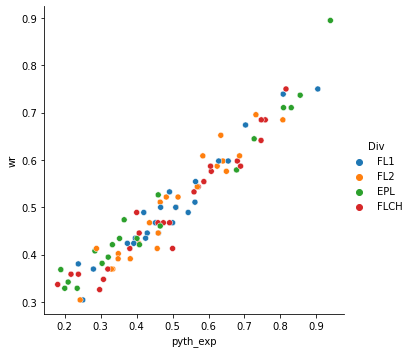

In [60]:
sns.relplot(x="pyth_exp", y="wr", data=main_df, hue="Div")

In [61]:
# Finally we generate a regression.

pyth_lm = smf.ols(formula = 'wr ~ pyth_exp', data=main_df).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wr   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           8.87e-55
Time:                        13:23:31   Log-Likelihood:                 187.39
No. Observations:                  92   AIC:                            -370.8
Df Residuals:                      90   BIC:                            -365.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1803      0.010     18.804      0.000       0.161       0.199
pyth_exp       0.6502      0.018     35.561      0.000       0.614       0.687
==============================================================================
Omnibus:                        3.561   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.898
Skew:                           0.327   Prob(JB):                        0.235
Kurtosis:                       3.574   Cond. No.                         6.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""